In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys

import momepy
import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
gdf = kf.load_obj(root_path,"raw_gdf_StPauls")

In [185]:
Road = gdf.loc[gdf["Type"]=="Road",:].reset_index(drop=True)
A_Road = Road.loc[Road["Name"]=='A Road',:].reset_index(drop=True)

In [186]:
A_Road["Length"] = A_Road.geometry.length
A_Road

,Type,Name,Details_Str,Details_Float,geometry,Length
0,Road,A Road,A13,NaN,"LINESTRING Z (534373.000 181318.000 0.000, 534...",43.000000
1,Road,A Road,A13,NaN,"LINESTRING Z (534416.000 181318.000 0.000, 534...",4.000000
2,Road,A Road,A13,NaN,"LINESTRING Z (534420.000 181318.000 0.000, 534...",84.260727
3,Road,A Road,A13,NaN,"LINESTRING Z (534504.250 181318.850 0.000, 534...",45.787390
4,Road,A Road,A13,NaN,"LINESTRING Z (534550.000 181317.000 0.000, 534...",2.001091
...,...,...,...,...,...,...
1568,Road,A Road,A302,NaN,"LINESTRING Z (530038.580 179565.830 0.000, 530...",41.589645
1569,Road,A Road,A302,NaN,"LINESTRING Z (530038.580 179565.830 0.000, 530...",63.388212
1570,Road,A Road,A302,NaN,"LINESTRING Z (530099.000 179585.000 0.000, 530...",33.788770
1571,Road,A Road,A302,NaN,"LINESTRING Z (530067.090 179596.110 0.000, 530...",77.720868


In [110]:
def remove_multipart(in_gdf):
    gdf_a = in_gdf[in_gdf.geom_type == 'LineString']
    gdf_b = in_gdf[in_gdf.geom_type == 'MultiLineString']

    gdf_b = gdf_b.explode()

    gdf = gdf_a.append(gdf_b)
    return gdf

In [187]:
G = momepy.gdf_to_nx(remove_multipart(A_Road), approach="primal", angles=True, length="Length")

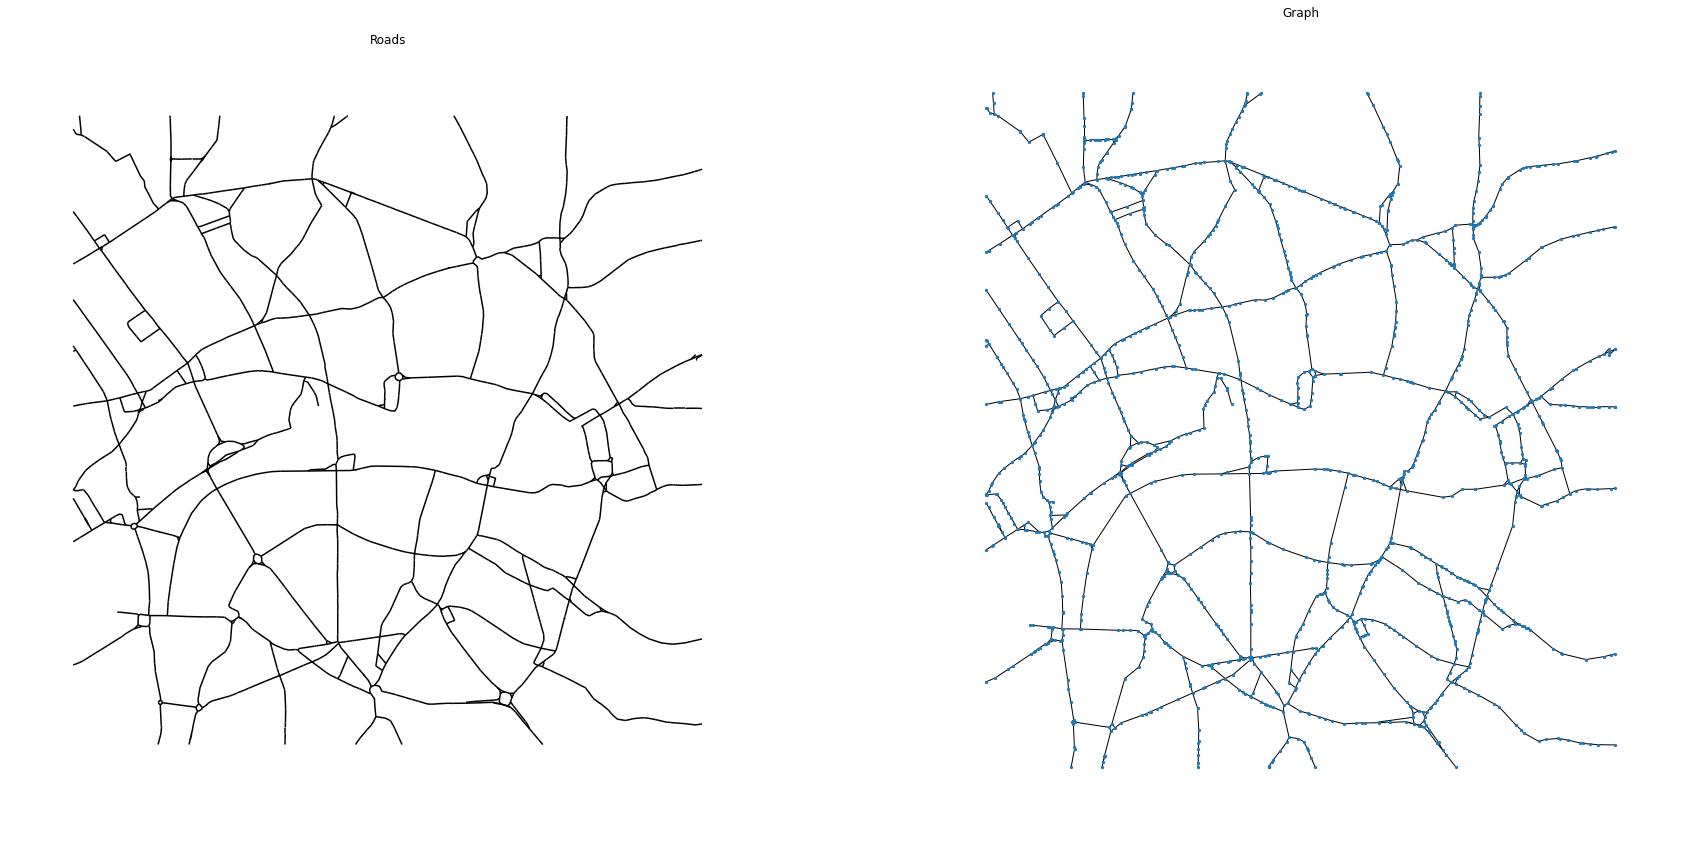

In [188]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Roads", "Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)

In [189]:
nodes_to_remove = [n for n in G.nodes if len(list(G.neighbors(n))) == 2]

In [190]:
G2 = G.copy()

#answer from https://stackoverflow.com/questions/56380053/combine-edges-when-node-degree-is-n-in-networkx
for node in nodes_to_remove:
    # We add an edge between neighbors (len == 2 so it is correct)
    G2.add_edge(*G2.neighbors(node))
    # And delete the node
    G2.remove_node(node)

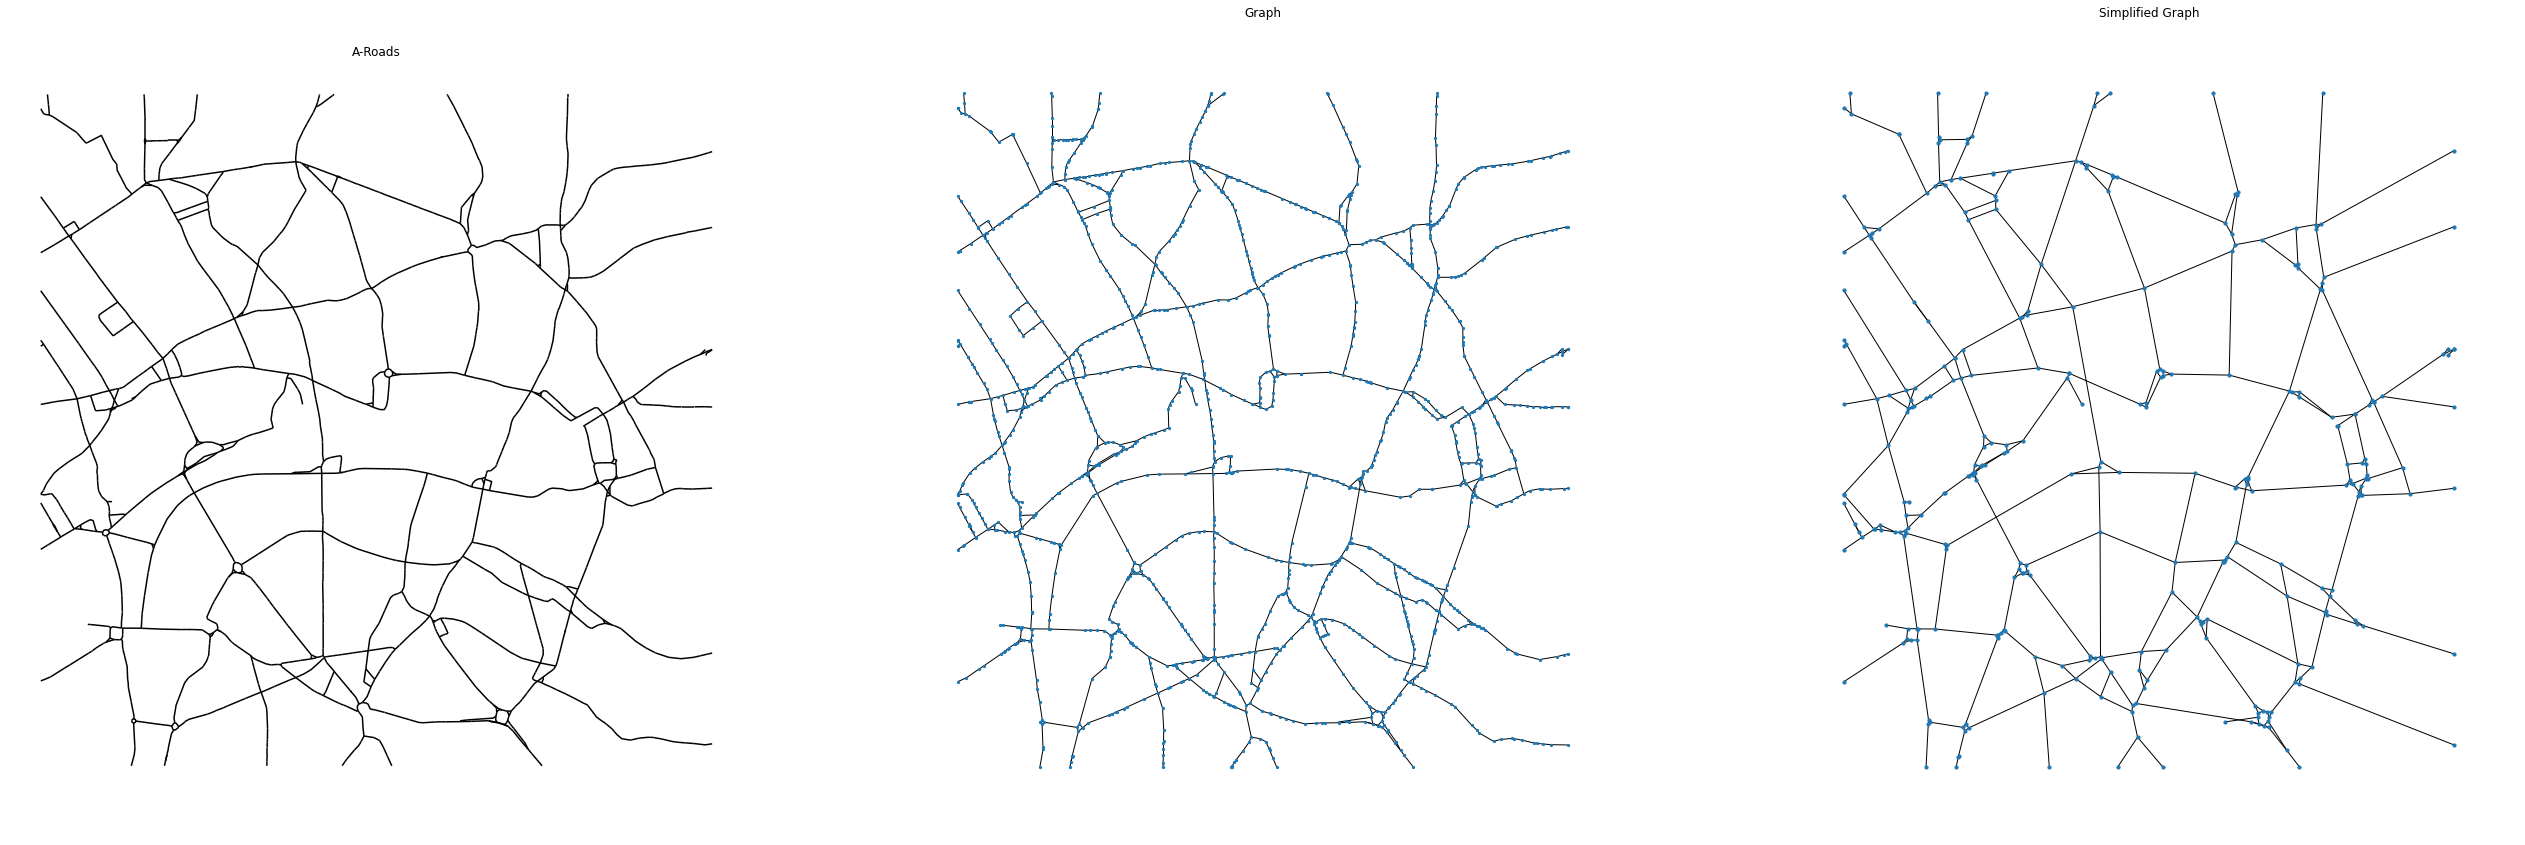

In [191]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# Plot
f, ax = plt.subplots(1, 3, figsize=(45, 15))
A_Road.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("A-Roads", "Graph", "Simplified Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)
nx.draw(G2, positions, ax=ax[2], node_size=10)